In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg
import gdown

# Load the datasets

In [2]:
gdown.download(
    'https://drive.google.com/uc?id=1i5Yj7Hh6ZYn9MpJ5hikOqA-SvnYK4zvQ',
    'cao2018-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1i5Yj7Hh6ZYn9MpJ5hikOqA-SvnYK4zvQ
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/cao2018-expressions.h5ad
19.5MB [00:00, 74.1MB/s]


'cao2018-expressions.h5ad'

In [3]:
scrna = sc.read('cao2018-expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 7362 × 4000
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_type', 'gene_short_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'neighbors', 'replicate_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=1BujbHCgZxjS2K7lxxQ1XXLQJ2lPDnpZN',
    'cao2018-peaks.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1BujbHCgZxjS2K7lxxQ1XXLQJ2lPDnpZN
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/cao2018-peaks.h5ad
34.2MB [00:00, 80.8MB/s]


'cao2018-peaks.h5ad'

In [5]:
scatac = sc.read_h5ad('cao2018-peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 7362 × 41524
    obs: 'replicate', 'cell_type', 'nb_features'
    var: 'chr', 'start', 'end', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'replicate_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [6]:
model = mtg.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['RNA'], ['ATAC']],
    pair_groups=[[0], [0]],
    condition=False,
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'leakyrelu'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=0, # don't have here as 1 dataset
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [7]:
model.train(
    n_iters=7000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=3500,
    validate_every=1000,
    verbose=1
)

 |████████████████████| 100.0% iter=7000/7000, time=25.31(s), loss=0.1963, recon=0.1961, kl=27.6604, integ=0.0000, cycle=0.0000, val_loss=0.1982, val_recon=0.1980, val_kl=26.9701, val_integ=0.0000, val_cycle=0.0000

### Plot training history

In [8]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,1000,0.203485,0.203466,11.038781,0.0,0.0,0.210075,0.210042,11.527170,0,0
1,2000,0.205899,0.205830,15.273224,0.0,0.0,0.203615,0.203518,17.006240,0,0
2,3000,0.212093,0.211953,19.354083,0.0,0.0,0.200771,0.200601,19.830084,0,0
3,4000,0.199053,0.198829,23.151966,0.0,0.0,0.199365,0.199132,23.294607,0,0
4,5000,0.199210,0.198950,25.979380,0.0,0.0,0.198769,0.198520,24.879028,0,0
5,6000,0.198652,0.198383,26.868045,0.0,0.0,0.198463,0.198206,25.653712,0,0
6,6999,0.196349,0.196072,27.660414,0.0,0.0,0.198231,0.197962,26.970111,0,0


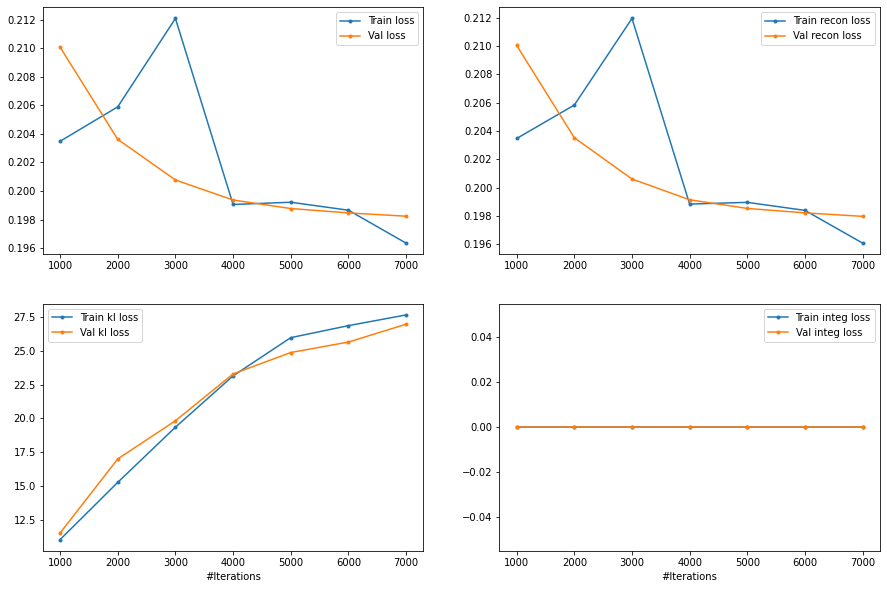

In [9]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Validation

### UMAP plot of the latent space

In [10]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['RNA'], ['ATAC']],
    pair_groups=[[0], [0]],
    batch_size=64,
    layers=[['count'], [None]]
)
z

AnnData object with n_obs × n_vars = 7362 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [11]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


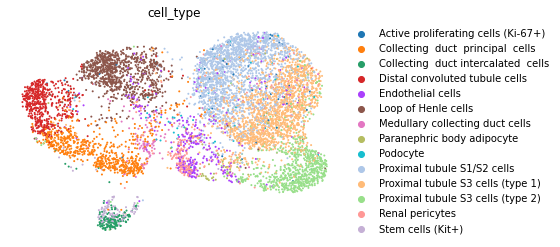

In [12]:
sc.pl.umap(z, color='cell_type', ncols=1, frameon=False)

In [13]:
z.write('../data/integrated/multigrate/cao-multigrate.h5ad')

## Remove old files

In [14]:
!rm 'cao2018-expressions.h5ad'
!rm 'cao2018-peaks.h5ad'